# Import libraries

In [3]:
from utils.client import Client
from utils.server import Server
import os
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Check GPU

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices()
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Helper Funtions

## Data processing

In [6]:
def get_df_from_all_dir(dir):
  data_paths = []
  data_labels = []

  for label in os.listdir(dir):
      for image in os.listdir(dir+label):
          data_paths.append(dir+label+'/'+image)
          data_labels.append(label)

  data_paths, data_labels = shuffle(data_paths, data_labels)

  Fseries = pd.Series(data_paths, name= 'filepaths')
  Lseries = pd.Series(data_labels, name='labels')

  return pd.concat([Fseries, Lseries], axis= 1)

In [7]:
def get_df_from_dir(dir):
  df = pd.DataFrame()  # Initialize df as an empty DataFrame

  for label in os.listdir(dir):
    data_paths = []
    data_labels = []
    for image in os.listdir(dir+label):
      data_paths.append(dir+label+'/'+image)
      data_labels.append(label)

      Fseries = pd.Series(data_paths, name= 'filepaths')
      Lseries = pd.Series(data_labels, name='labels')

      df.update({label: pd.concat([Fseries, Lseries], axis= 1)})

  return df

In [8]:
def generate_data_clients(number_of_clients, df):
    # Ensure all labels are present in the dataset
    labels = df['labels'].unique()
    if len(labels) < 4:
        raise ValueError("Dataset does not have all 4 required labels.")
    
    # Shuffle the DataFrame to ensure random distribution
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the dataset by labels
    label_groups = {label: df[df['labels'] == label] for label in labels}

    # Debugging print statements
    print("Number of samples per label:")
    for label, group in label_groups.items():
        print(f"{label}: {len(group)}")
    
    # Determine the number of samples per client per label
    clients_dataset = {client_id: pd.DataFrame(columns=df.columns) for client_id in range(number_of_clients)}
    for label, group in label_groups.items():
        samples_per_client = len(group) // number_of_clients
        if samples_per_client == 0:
            raise ValueError(f"Not enough samples for label '{label}' to distribute across clients.")
        
        # Distribute samples for the current label among clients
        for client_id in range(number_of_clients):
            start_index = client_id * samples_per_client
            end_index = start_index + samples_per_client
            client_data = group.iloc[start_index:end_index]

            clients_dataset[client_id] = pd.concat([clients_dataset[client_id], client_data])

        # Shuffle the DataFrame for each client to ensure random distribution
        for client_id in range(number_of_clients):
            clients_dataset[client_id] = clients_dataset[client_id].sample(frac=1).reset_index(drop=True)

    # Debugging print statements
    for client_id, client_data in clients_dataset.items():
        print(f"Client {client_id} has {len(client_data)} samples:")
        print(client_data['labels'].value_counts())

    return clients_dataset

In [9]:
# def generate_data_clients(number_of_clients, df):

#     number_of_samples = len(df['filepaths'])
#     number_of_samples_per_client = number_of_samples // number_of_clients

#     clients_dataset = {}

#     # Debugging print statement
#     print(f"Total samples: {len(df)}")

#     # Shuffle the DataFrame to ensure random distribution of data
#     # df = df.sample(frac=1).reset_index(drop=True)

#     # Calculate total samples needed
#     total_samples = number_of_clients * number_of_samples_per_client
#     if total_samples > len(df):
#         raise ValueError("There are not enough samples to distribute among clients.")

#     # Ensure each client gets the specified number of samples
#     for client_id in range(number_of_clients):
#         start_index = client_id * number_of_samples_per_client
#         end_index = start_index + number_of_samples_per_client
#         client_data = df.iloc[start_index:end_index]

#         # Assigning each client their slice of data
#         clients_dataset.update({client_id: client_data})

#     return clients_dataset

In [10]:
def generate_batch_data(data_batch_number, df, threshold):
    labels = list(df.keys())
    number_of_samples_per_set = threshold // data_batch_number
    batch_dataset = {}

    # Shuffle the DataFrame to ensure random distribution of data
    # df = df.sample(frac=1).reset_index(drop=True)

    # Calculate total samples needed
    # total_samples = number_of_clients * number_of_samples_per_client
    # if total_samples > len(df):
    #     raise ValueError("There are not enough samples to distribute among clients.")

    # Ensure each client gets the specified number of samples
    for numBatch in range(data_batch_number):
      start_index = numBatch * number_of_samples_per_set
      end_index = start_index + number_of_samples_per_set
      
      # Initialize an empty list to store the slices
      sliced_dfs = []
      
      # Loop through each DataFrame in the dictionary
      for name, dataFrame in df.items():
          # Slice the DataFrame from the specified range
          sliced_df = dataFrame.iloc[start_index:end_index]
          # Append the sliced DataFrame to the list
          sliced_dfs.append(sliced_df)

      # Concatenate all the sliced DataFrames into one
      batch_data = pd.concat(sliced_dfs, ignore_index=True)
      # Shuffle all the DataFrames
      batch_data = batch_data.sample(frac=1).reset_index(drop=True)

      # Assigning each client their slice of data
      batch_dataset.update({numBatch: batch_data})

    return batch_dataset

# Fine-tuning

In [11]:
DATASET_DIR = '../dataset/'
TRAIN_DIR = DATASET_DIR + '/Training/'
TEST_DIR = DATASET_DIR + '/Testing/'
CLASS_COUNT = len(os.listdir(TRAIN_DIR))
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
BATCH_SIZE = 32

CLIENTS = 5
ROUNDS = 5

In [10]:
# # Create dataset for each clients
# train_df = get_df_from_all_dir(TRAIN_DIR)
# test_df = get_df_from_all_dir(TEST_DIR)
# clients_dataset = generate_data_clients(CLIENTS * ROUNDS, train_df)
# train_df.to_csv('../data_df_6.csv')

# Populate the dataset for each clients

In [11]:
train_df = pd.read_csv('../data_df_6.csv')
test_df = get_df_from_all_dir(TEST_DIR)
clients_dataset = generate_data_clients(CLIENTS * ROUNDS, train_df)

Number of samples per label:
meningioma: 1339
notumor: 1595
pituitary: 1457
glioma: 1321
Client 0 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 1 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 2 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 3 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 4 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 5 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 6 has 226 samples:
labels
notumor       63
pituitary     58
meningioma    53
glioma        52
Name: count, dtype: int64
Client 7 has 226 sampl

In [12]:
clients_dataset

{0:     Unnamed: 0                                       filepaths      labels
 0         4479   ../dataset//Training/pituitary/Tr-pi_0907.jpg   pituitary
 1         3153  ../dataset//Training/meningioma/Tr-me_1075.jpg  meningioma
 2         2995     ../dataset//Training/notumor/Tr-no_0117.jpg     notumor
 3          371     ../dataset//Training/notumor/Tr-no_1167.jpg     notumor
 4         1220     ../dataset//Training/notumor/Tr-no_0074.jpg     notumor
 ..         ...                                             ...         ...
 221        132   ../dataset//Training/pituitary/Tr-pi_0465.jpg   pituitary
 222       1025  ../dataset//Training/meningioma/Tr-me_0363.jpg  meningioma
 223       4688  ../dataset//Training/meningioma/Tr-me_0102.jpg  meningioma
 224       2303   ../dataset//Training/pituitary/Tr-pi_0069.jpg   pituitary
 225        439     ../dataset//Training/notumor/Tr-no_0861.jpg     notumor
 
 [226 rows x 3 columns],
 1:     Unnamed: 0                                       f

In [13]:
clients_dataset[1]

,Unnamed: 0,filepaths,labels
0,2463,../dataset//Training/notumor/Tr-no_0130.jpg,notumor
1,5322,../dataset//Training/glioma/Tr-gl_0498.jpg,glioma
2,290,../dataset//Training/meningioma/Tr-me_0759.jpg,meningioma
3,4618,../dataset//Training/glioma/Tr-gl_0275.jpg,glioma
4,3149,../dataset//Training/pituitary/Tr-pi_1149.jpg,pituitary
...,...,...,...
221,4535,../dataset//Training/pituitary/Tr-pi_1226.jpg,pituitary
222,1295,../dataset//Training/meningioma/Tr-me_0951.jpg,meningioma
223,787,../dataset//Training/notumor/Tr-no_0078.jpg,notumor
224,4643,../dataset//Training/glioma/Tr-gl_0904.jpg,glioma


# Training colaborativ model

## Simulate the collaborative environment

In [14]:
# Initialize server and server
server = Server(model_save_path='./server_model')

clients = [Client(client_id=i, server=server) for i in range(CLIENTS)]

In [15]:
test_gen = ImageDataGenerator().flow_from_dataframe(
          test_df, x_col='filepaths', y_col='labels', target_size=(128, 128), class_mode='categorical', batch_size=BATCH_SIZE
      )

# Debugging print statement
for data_batch, labels_batch in test_gen:
    print(f"Data batch shape: {data_batch.shape}, Labels batch shape: {labels_batch.shape}")
    break  # Only print the first batch to avoid excessive output

Found 1311 validated image filenames belonging to 4 classes.
Data batch shape: (32, 128, 128, 3), Labels batch shape: (32, 4)


In [16]:
len(clients_dataset[1])

226

## Training part

In [17]:
cnn_acc = []
cnn_loss = []
XTIME = 15

In [18]:
import time  # Import the time module

# Initialize a timer for the entire process
start_time = time.time()

for _ in range(XTIME):
    i = 0

    for round in range(ROUNDS):
        round_start_time = time.time()  # Track the time for each round

        for client in clients:
            client.get_global_model()  # Get the latest global model
            client.clear_local_df()  # Clear the local dataset
            client.append_df_to_local_df(clients_dataset[i])  # Add the client's dataset
            client.re_train_model(epochs=10)  # Retrain the model
            i += 1

        server.aggregate_client_models()  # Aggregate models from all clients

        # Evaluate the global model
        loss, accuracy = server.evaluate(test_gen)
        print(f"\n({round + 1}) Global Model Test Loss: {loss}, Test Accuracy: {accuracy}\n")
        cnn_acc.append(accuracy)
        cnn_loss.append(loss)

        # Display the time taken for the round
        round_time = time.time() - round_start_time
        print(f"Round {round + 1} training time: {round_time:.2f} seconds")

# Calculate total training time
total_time = time.time() - start_time
print(f"\nTotal training time for {XTIME * ROUNDS} rounds: {total_time:.2f} seconds")

Initial local_df shape: (226, 3)
Train_df shape: (158, 3), Valid_df shape: (68, 3)
Found 158 validated image filenames belonging to 4 classes.
Found 68 validated image filenames belonging to 4 classes.
Epoch 1/10
5/5 [==============================] - 16s 1s/step - loss: 3.4430 - accuracy: 0.1582 - val_loss: 5.7923 - val_accuracy: 0.2353
Epoch 2/10
5/5 [==============================] - 1s 268ms/step - loss: 3.1291 - accuracy: 0.2468 - val_loss: 6.0073 - val_accuracy: 0.1912
Epoch 3/10
5/5 [==============================] - 1s 268ms/step - loss: 3.1193 - accuracy: 0.2468 - val_loss: 5.4838 - val_accuracy: 0.2500
Epoch 4/10
5/5 [==============================] - 1s 268ms/step - loss: 2.9780 - accuracy: 0.2278 - val_loss: 5.4415 - val_accuracy: 0.2206
Epoch 5/10
5/5 [==============================] - 1s 271ms/step - loss: 3.0323 - accuracy: 0.2532 - val_loss: 5.1339 - val_accuracy: 0.2059
Epoch 6/10
5/5 [==============================] - 1s 264ms/step - loss: 2.6249 - accuracy: 0.3101 - 

In [19]:
cnn_acc

[0.4385964870452881,
 0.6681922078132629,
 0.7208238244056702,
 0.746758222579956,
 0.7658275961875916,
 0.7856597900390625,
 0.8131197690963745,
 0.8199847340583801,
 0.8344774842262268,
 0.8550724387168884,
 0.8672769069671631,
 0.8749046325683594,
 0.873379111289978,
 0.8771929740905762,
 0.8832951784133911,
 0.8954996466636658,
 0.8970251679420471,
 0.8977879285812378,
 0.8993135094642639,
 0.9023646116256714,
 0.9099923968315125,
 0.9138062596321106,
 0.9160946011543274,
 0.9206712245941162,
 0.9321128726005554,
 0.9313501119613647,
 0.936689555644989,
 0.9382150769233704,
 0.936689555644989,
 0.9412662386894226,
 0.9420289993286133,
 0.9443173408508301,
 0.9443173408508301,
 0.9466056227684021,
 0.9458428621292114,
 0.9496567249298096,
 0.9549961686134338,
 0.9496567249298096,
 0.9496567249298096,
 0.952707827091217,
 0.9534706473350525,
 0.9557589888572693,
 0.950419545173645,
 0.952707827091217,
 0.9519450664520264,
 0.9549961686134338,
 0.9580472707748413,
 0.9557589888572693,

In [20]:
cnn_loss

[1.7392956018447876,
 0.9953315258026123,
 0.8396357297897339,
 0.7620393633842468,
 0.6903330087661743,
 0.6304722428321838,
 0.5751442909240723,
 0.5358757972717285,
 0.5019260048866272,
 0.44041818380355835,
 0.40859726071357727,
 0.38887473940849304,
 0.38267782330513,
 0.3765142261981964,
 0.3339875042438507,
 0.30875149369239807,
 0.2972160577774048,
 0.2911604046821594,
 0.2876419126987457,
 0.27233701944351196,
 0.25307342410087585,
 0.23997333645820618,
 0.22871455550193787,
 0.2232259064912796,
 0.2077363133430481,
 0.19505350291728973,
 0.19220076501369476,
 0.18974171578884125,
 0.1885448843240738,
 0.17984606325626373,
 0.17371053993701935,
 0.1672721952199936,
 0.1714971661567688,
 0.169894278049469,
 0.1604084074497223,
 0.15050968527793884,
 0.14635036885738373,
 0.1526198387145996,
 0.14518018066883087,
 0.1367301493883133,
 0.137742817401886,
 0.13724656403064728,
 0.14107032120227814,
 0.13331076502799988,
 0.130630761384964,
 0.1288672685623169,
 0.12410234659910202

# Evaluating

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
chart_save_path = './save_st/'

model_loaded = tf.keras.models.load_model('./server_model/global_model.h5')


In [12]:
test_df = get_df_from_all_dir(TEST_DIR)

test_gen = ImageDataGenerator().flow_from_dataframe(
          test_df, x_col='filepaths', y_col='labels', target_size=(128, 128), shuffle=False, class_mode='categorical', batch_size=BATCH_SIZE
      )

Found 1311 validated image filenames belonging to 4 classes.


In [13]:
preds = model_loaded.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

classes = list(test_gen.class_indices.keys())

41/41 [==============================] - 9s 132ms/step


In [14]:
test_loss, test_acc = model_loaded.evaluate(test_gen, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

41/41 - 3s - loss: 0.1001 - accuracy: 0.9687 - 3s/epoch - 83ms/step

Test accuracy: 0.9687


In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.94      0.94      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



Confusion Matrix, Without Normalization
[[279  17   0   4]
 [  2 289  10   5]
 [  0   1 404   0]
 [  0   2   0 298]]


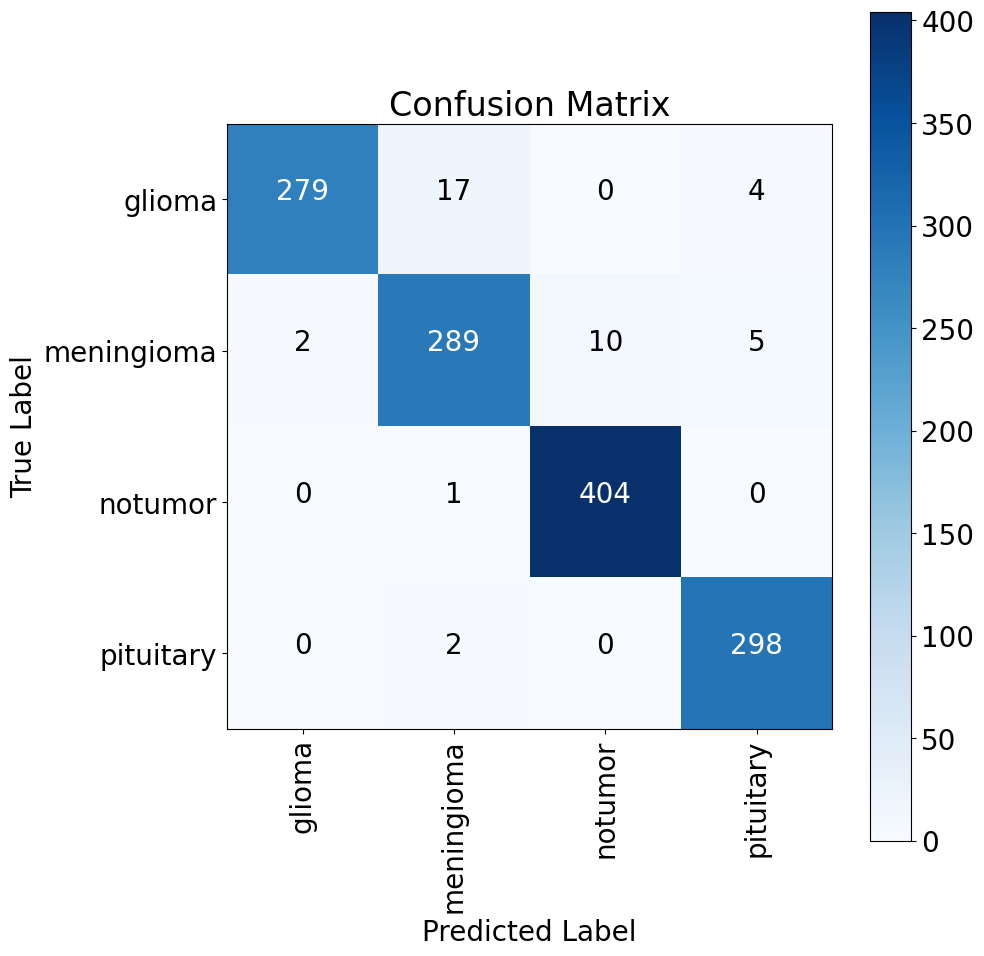

In [22]:
import itertools
def plot_confusion_matrix(cm, classes, model, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	model_name = model.input_names[0][:-6]
	plt.figure(figsize= (10, 10))
	plt.rcParams.update({'font.size': 20})
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	plt.grid(False)

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 90)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')
	plt.savefig(chart_save_path + f'{model_name}_confusion_matrix.pdf')

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, model= model_loaded, title = 'Confusion Matrix')

In [23]:
save_path = 'save_st/'
Epochs = list(range(1, ROUNDS + 1))

In [25]:
XTIME = 15

In [27]:
cnn_acc = [0.4385964870452881,
 0.6681922078132629,
 0.7208238244056702,
 0.746758222579956,
 0.7658275961875916,
 0.7856597900390625,
 0.8131197690963745,
 0.8199847340583801,
 0.8344774842262268,
 0.8550724387168884,
 0.8672769069671631,
 0.8749046325683594,
 0.873379111289978,
 0.8771929740905762,
 0.8832951784133911,
 0.8954996466636658,
 0.8970251679420471,
 0.8977879285812378,
 0.8993135094642639,
 0.9023646116256714,
 0.9099923968315125,
 0.9138062596321106,
 0.9160946011543274,
 0.9206712245941162,
 0.9321128726005554,
 0.9313501119613647,
 0.936689555644989,
 0.9382150769233704,
 0.936689555644989,
 0.9412662386894226,
 0.9420289993286133,
 0.9443173408508301,
 0.9443173408508301,
 0.9466056227684021,
 0.9458428621292114,
 0.9496567249298096,
 0.9549961686134338,
 0.9496567249298096,
 0.9496567249298096,
 0.952707827091217,
 0.9534706473350525,
 0.9557589888572693,
 0.950419545173645,
 0.952707827091217,
 0.9519450664520264,
 0.9549961686134338,
 0.9580472707748413,
 0.9557589888572693,
 0.9549961686134338,
 0.95652174949646,
 0.9626239538192749,
 0.9633867144584656,
 0.9588100910186768,
 0.9603356122970581,
 0.9618611931800842,
 0.9626239538192749,
 0.966437816619873,
 0.9618611931800842,
 0.9626239538192749,
 0.9618611931800842,
 0.966437816619873,
 0.9694889187812805,
 0.9633867144584656,
 0.9649122953414917,
 0.9687261581420898,
 0.970251739025116,
 0.966437816619873,
 0.966437816619873,
 0.9649122953414917,
 0.9679633975028992,
 0.9717772603034973,
 0.9733028411865234,
 0.9717772603034973,
 0.9710144996643066,
 0.9687261581420898]

cnn_loss = [1.7392956018447876,
 0.9953315258026123,
 0.8396357297897339,
 0.7620393633842468,
 0.6903330087661743,
 0.6304722428321838,
 0.5751442909240723,
 0.5358757972717285,
 0.5019260048866272,
 0.44041818380355835,
 0.40859726071357727,
 0.38887473940849304,
 0.38267782330513,
 0.3765142261981964,
 0.3339875042438507,
 0.30875149369239807,
 0.2972160577774048,
 0.2911604046821594,
 0.2876419126987457,
 0.27233701944351196,
 0.25307342410087585,
 0.23997333645820618,
 0.22871455550193787,
 0.2232259064912796,
 0.2077363133430481,
 0.19505350291728973,
 0.19220076501369476,
 0.18974171578884125,
 0.1885448843240738,
 0.17984606325626373,
 0.17371053993701935,
 0.1672721952199936,
 0.1714971661567688,
 0.169894278049469,
 0.1604084074497223,
 0.15050968527793884,
 0.14635036885738373,
 0.1526198387145996,
 0.14518018066883087,
 0.1367301493883133,
 0.137742817401886,
 0.13724656403064728,
 0.14107032120227814,
 0.13331076502799988,
 0.130630761384964,
 0.1288672685623169,
 0.12410234659910202,
 0.12999868392944336,
 0.13012410700321198,
 0.12599800527095795,
 0.118827685713768,
 0.11578633636236191,
 0.1253776252269745,
 0.1167239174246788,
 0.11550101637840271,
 0.11404396593570709,
 0.11208830773830414,
 0.11856105923652649,
 0.1133185625076294,
 0.11472851037979126,
 0.1051175519824028,
 0.10255169123411179,
 0.10764379799365997,
 0.11012806743383408,
 0.1049225851893425,
 0.10424628108739853,
 0.10195570439100266,
 0.10435141623020172,
 0.11201725900173187,
 0.10772145539522171,
 0.10271654278039932,
 0.09476910531520844,
 0.10004872828722,
 0.09967923164367676,
 0.10012200474739075]

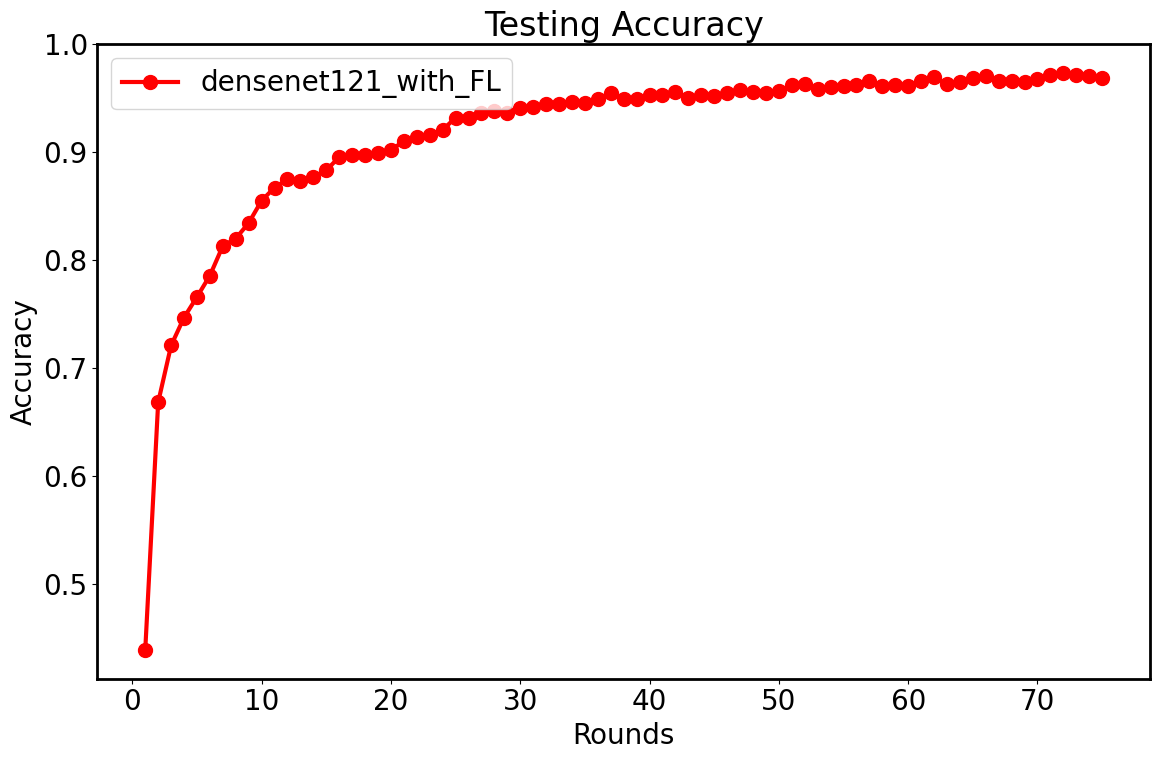

In [28]:
import matplotlib
import matplotlib.ticker

model_name = model_loaded.input_names[0][:-6]


save_path = 'save_st/'
Epochs = list(range(1, XTIME * ROUNDS + 1))

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
ax.set_facecolor('white')  # Set the background color of the axes
ax.spines['top'].set_color('black')  # Set top spine color to black
ax.spines['right'].set_color('black')  # Set right spine color to black
ax.spines['bottom'].set_color('black')  # Set bottom spine color to black
ax.spines['left'].set_color('black')  # Set left spine color to black

# Set the thickness of the spines
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Ensure only one label per integer value
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))  # Ensures ticks are spaced properly
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.plot(Epochs, cnn_acc, 'r', marker='o', markersize=10, label=f'{model_name}_with_FL', linewidth=3)
# plt.plot(Epochs, vgg19_accuracy, 'g', marker='s', markersize=10, label='VGG19', linewidth=3)
# plt.plot(Epochs, efficientnet_accuracy, 'b', marker='^', markersize=10, label='EfficientNetV2B3', linewidth=3)
# plt.plot(Epochs, densenet_accuracy, 'c', marker='*', markersize=10, label='DenseNet201', linewidth=3)
# plt.plot(Epochs, mobilenet_accuracy, 'm', marker='x', markersize=10, label='MobileNetV3Large', linewidth=3)
# plt.plot(Epochs, xception_accuracy, 'y', marker='d', markersize=10, label='Xception', linewidth=3)
# plt.plot(Epochs, inception_accuracy, 'orange', marker='p', markersize=10, label='InceptionV3', linewidth=3)

plt.title('Testing Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend(loc="best", frameon=True, facecolor='white')
plt.tight_layout()
plt.grid(False)
plt.savefig(save_path + 'training_accuracy_plot.pdf', facecolor='white')
plt.show()

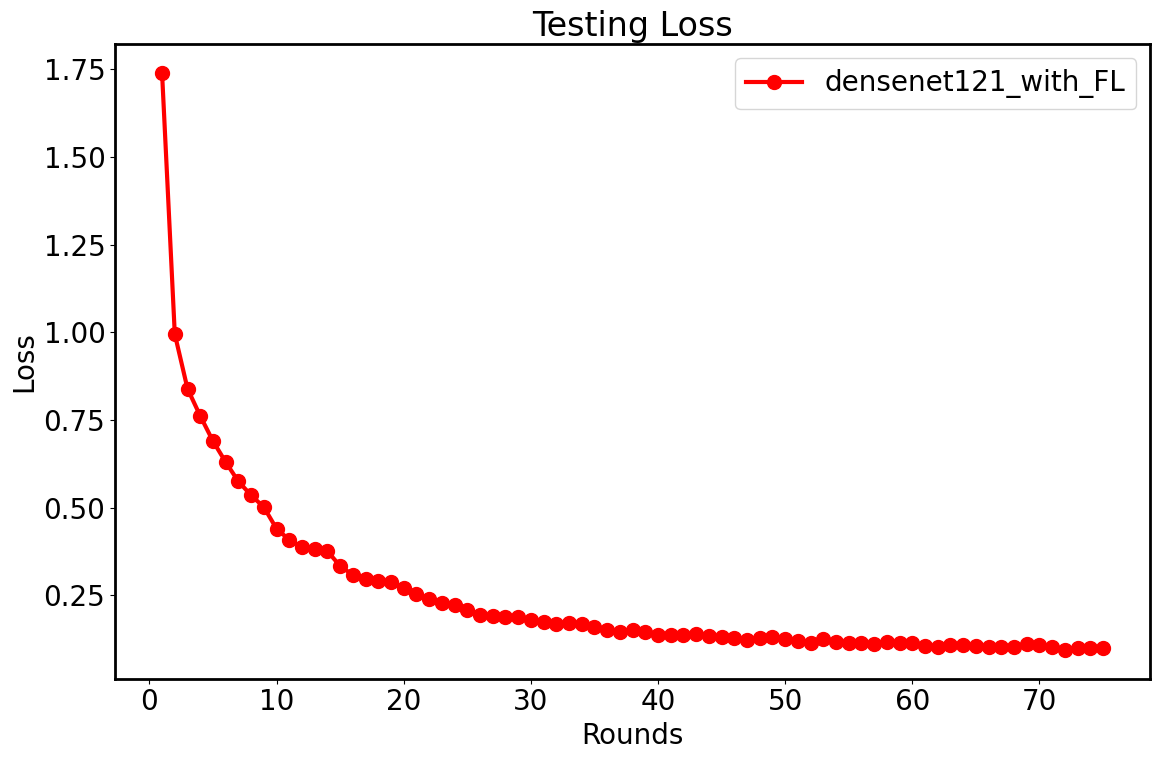

In [29]:
import matplotlib
import matplotlib.ticker

model_name = model_loaded.input_names[0][:-6]

save_path = 'save_st/'
Epochs = list(range(1, XTIME * ROUNDS + 1))

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
ax.set_facecolor('white')  # Set the background color of the axes
ax.spines['top'].set_color('black')  # Set top spine color to black
ax.spines['right'].set_color('black')  # Set right spine color to black
ax.spines['bottom'].set_color('black')  # Set bottom spine color to black
ax.spines['left'].set_color('black')  # Set left spine color to black

# Set the thickness of the spines
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Ensure only one label per integer value
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))  # Ensures ticks are spaced properly
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.plot(Epochs, cnn_loss, 'r', marker='o', markersize=10, label=f'{model_name}_with_FL', linewidth=3)
# plt.plot(Epochs, vgg19_accuracy, 'g', marker='s', markersize=10, label='VGG19', linewidth=3)
# plt.plot(Epochs, efficientnet_accuracy, 'b', marker='^', markersize=10, label='EfficientNetV2B3', linewidth=3)
# plt.plot(Epochs, densenet_accuracy, 'c', marker='*', markersize=10, label='DenseNet201', linewidth=3)
# plt.plot(Epochs, mobilenet_accuracy, 'm', marker='x', markersize=10, label='MobileNetV3Large', linewidth=3)
# plt.plot(Epochs, xception_accuracy, 'y', marker='d', markersize=10, label='Xception', linewidth=3)
# plt.plot(Epochs, inception_accuracy, 'orange', marker='p', markersize=10, label='InceptionV3', linewidth=3)

plt.title('Testing Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend(loc="best", frameon=True, facecolor='white')
plt.tight_layout()
plt.grid(False)
plt.savefig(save_path + 'training_loss_plot.pdf', facecolor='white')
plt.show()

In [30]:
test_df

,filepaths,labels
0,../dataset//Testing/notumor/Te-no_0255.jpg,notumor
1,../dataset//Testing/meningioma/Te-me_0138.jpg,meningioma
2,../dataset//Testing/meningioma/Te-me_0065.jpg,meningioma
3,../dataset//Testing/meningioma/Te-me_0202.jpg,meningioma
4,../dataset//Testing/notumor/Te-no_0312.jpg,notumor
...,...,...
1306,../dataset//Testing/notumor/Te-no_0245.jpg,notumor
1307,../dataset//Testing/pituitary/Te-pi_0080.jpg,pituitary
1308,../dataset//Testing/notumor/Te-no_0272.jpg,notumor
1309,../dataset//Testing/meningioma/Te-me_0136.jpg,meningioma


In [31]:
y_true = test_gen.classes
y_true

[2,
 1,
 1,
 1,
 2,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 2,
 3,
 1,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 2,
 0,
 1,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 3,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 3,
 2,
 0,
 3,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 3,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 3,
 1,
 0,
 1,
 3,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 3,
 0,
 0,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 0,
 2,
 2,
 0,
 0,
 1,
 3,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 3,
 3,
 3,
 0,
 3,
 3,
 1,
 1,
 2,
 2,
 3,
 0,
 2,
 2,
 0,
 3,
 0,
 2,
 1,
 2,
 3,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 1,
 3,
 0,
 1,
 3,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 3,
 1,
 0,
 1,
 2,
 2,
 2,
 3,
 3,
 0,
 1,
 2,
 3,
 2,
 0,
 2,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 3,
 0,
 2,
 0,
 2,
 1,
 0,
 3,
 3,
 2,
 0,
 2,
 0,
 0,
 3,
 1,
 2,
 2,
 0,
 0,
 2,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 2,
 2,
 3,


In [32]:
y_pred_proba = preds
y_pred_proba

array([[1.0279465e-07, 1.9137135e-06, 9.9999785e-01, 6.4709710e-08],
       [2.2245757e-05, 9.9997759e-01, 7.5447886e-08, 1.9264851e-08],
       [1.1048062e-05, 9.9530774e-01, 4.6629380e-03, 1.8239931e-05],
       ...,
       [3.6326469e-07, 1.3505297e-05, 9.9998617e-01, 2.2444926e-10],
       [8.6506559e-03, 9.5650172e-01, 1.5067385e-04, 3.4697000e-02],
       [1.2644421e-04, 2.7369208e-06, 9.9986136e-01, 9.4419765e-06]],
      dtype=float32)

In [33]:
test_gen.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true are your true labels and y_pred_proba are the predicted probabilities
# Replace these with your actual data
# y_true = ...
# y_pred_proba = ...

# Define the number of classes and binarize the labels
n_classes = 4  # Number of classes: no tumor, pituitary, meningioma, glioma
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



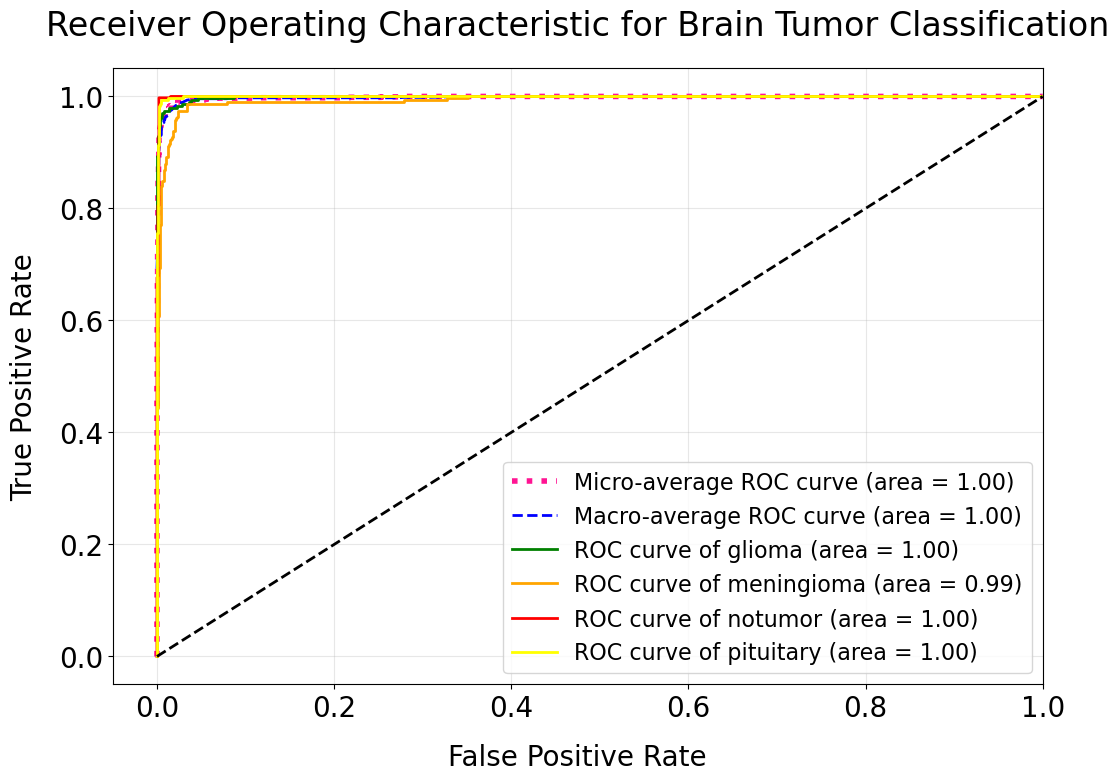

In [35]:
# Plot all ROC curves
plt.figure(figsize=(12, 8))

# Plot micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color="deeppink",
    linestyle=":",
    linewidth=4,
    label="Micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
)

# Plot macro-average ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color="blue",
    linestyle="--",
    linewidth=2,
    label="Macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
)

# Plot ROC curve for each class
colors = ["green", "orange", "red", "yellow"]
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i, color in enumerate(colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linewidth=2,
        label="ROC curve of {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

# Plot diagonal line
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Set limits for axes
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])


# Customize axis labels
plt.xlabel("False Positive Rate", fontsize=20, labelpad=15)  # Add padding for better spacing
plt.ylabel("True Positive Rate", fontsize=20, labelpad=15)
plt.title("Receiver Operating Characteristic for Brain Tumor Classification", pad=24)

# Add a legend with adjusted font size and location
plt.legend(loc="lower right", fontsize=16, frameon=True, fancybox=True)

# Add gridlines with transparency for clarity
plt.grid(alpha=0.3)

plt.savefig(save_path + 'ROC_curve.pdf', facecolor='white')

plt.show()
